In [6]:
import pickle, pandas, numpy
import seaborn as sns
from unittest import result
from collections import Counter
from prettytable import PrettyTable
import matplotlib.pyplot as plt
def load_data(filename):
    f = open(filename, 'rb')
    loaded_data = pickle.load(f)
    f.close()
    return loaded_data
    
def get_values(val_score):
    M_fpr = [i["M_fpr"] for i in val_score]
    M_fnr = [i["M_fnr"] for i in val_score]
    M_F1 = [i["M_F1"] for i in val_score]
    W_fpr = [i["W_fpr"] for i in val_score]
    W_fnr = [i["W_fnr"] for i in val_score]
    W_f1 = [i["W_f1"] for i in val_score]
    ACC = [i["ACC"] for i in val_score]
    return [M_fpr, M_fnr, M_F1, W_fpr, W_fnr, W_f1, ACC]


def show_table(savename):
    fold_result_dict = {}
    filename = "./save/result/" + savename + ".result"
    fold_result_dict = load_data(filename)
    train_table = PrettyTable(['typ', 'epo', 'loss', 'M_fpr', 'M_fnr', 'M_F1', 'W_fpr', 'W_fnr', 'W_f1', 'ACC'])
    test_table = PrettyTable(['typ', 'epo', 'loss', 'M_fpr', 'M_fnr', 'M_F1', 'W_fpr', 'W_fnr', 'W_f1', 'ACC'])
    # print(fold_result_dict)
    for i in fold_result_dict:
        train_table.add_row(["tra", str(i+1), format(fold_result_dict[i]["train_loss"], '.4f')] + \
            [fold_result_dict[i]["train_score"][j] for j in fold_result_dict[i]["train_score"] if j != "MCM"])
        test_table.add_row(["val", str(i+1), format(fold_result_dict[i]["val_loss"], '.4f')] + \
            [fold_result_dict[i]["val_score"][j] for j in fold_result_dict[i]["val_score"] if j != "MCM"])
        # if i == 200: break
    max_mf1 = 0
    for i in fold_result_dict:
        if float(fold_result_dict[i]["val_score"]["M_f1"]) >= max_mf1:
            max_mf1 = float(fold_result_dict[i]["val_score"]["M_f1"])
            max_item = i
    # max_mf1 =  max([float(fold_result_dict[i]["val_score"]["M_f1"]) for i in fold_result_dict])
    mean_mf1 =  sum([float(fold_result_dict[i]["val_score"]["M_f1"]) for i in fold_result_dict][-3:])/3
    sns.lineplot(data = pandas.Series([float(fold_result_dict[i]["val_score"]["M_f1"]) for i in fold_result_dict],name='value'))
    # plt.ylim((80, 100))
    # plt.show()
    print(filename)
    # print(train_table)
    # print(test_table)
    print(max_mf1)
    print(mean_mf1)
    print(max_item)
    return max_mf1, mean_mf1, max_item
   
def evaluate(savename):
    max_mf1, mean_mf1, max_item = show_table(savename)
    return max_mf1, mean_mf1, max_item

def get_MCM(savename, choice):
    fold_result_dict = {}
    filename = "./save/result/" + savename + ".result"
    fold_result_dict = load_data(filename)
    MCM_result = {"MCM_train":[], "MCM_val":[]}
    for i in fold_result_dict:   # 训练的轮数
        MCM_train = fold_result_dict[i]["train_score"]["MCM"]
        MCM_val = fold_result_dict[i]["val_score"]["MCM"]
        MCM_result["MCM_train"].append(MCM_train)
        MCM_result["MCM_val"].append(MCM_val)
    if choice != 1:
        max_mf1 = 0
        for i in fold_result_dict:
            if float(fold_result_dict[i]["val_score"]["M_f1"]) >= max_mf1:
                max_mf1 = float(fold_result_dict[i]["val_score"]["M_f1"])
                max_item = i
            if i == choice-1: break
    else:
        max_num = sorted(dict(Counter([float(fold_result_dict[i]["val_score"]["M_f1"]) for i in fold_result_dict]))\
                    .items(), key=lambda x: x[1], reverse=True)[0][0]
        
        for index, concret in enumerate([float(fold_result_dict[i]["val_score"]["M_f1"]) for i in fold_result_dict]):
            if concret == max_num:max_item = index
        # print(max_num, index)
    return MCM_result, int(max_item)

def get_allkfold_MCM(filename):
    MCM_all = {}
    for fold_num in range(10):
        save_name_ce = "CE_Kfold_" + str(fold_num) + "_" + filename + "_bat32"
        MCM_all[fold_num] = get_MCM(save_name_ce)
    return MCM_all

def analyse_MCM(MCM_all , epoch = 99 ):
    MCM = MCM_all["MCM_val"][epoch]
    tn = MCM[:, 0, 0]
    fp = MCM[:, 0, 1]
    fn = MCM[:, 1, 0] 
    tp = MCM[:, 1, 1] 
    fpr_array = fp / (fp + tn)
    fnr_array = fn / (tp + fn)
    f1_array = 2 * tp / (2 * tp + fp + fn)
    sum_array = fn + tp
    M_fpr = fpr_array.mean()
    M_fnr = fnr_array.mean()
    M_F1 = f1_array.mean()
    W_fpr = (fpr_array * sum_array).sum() / sum( sum_array )
    W_fnr = (fnr_array * sum_array).sum() / sum( sum_array )
    W_f1 = (f1_array * sum_array).sum() / sum( sum_array )
    # print(M_fpr, M_fnr, M_F1, W_fpr, W_fnr, W_f1)
    result = pandas.DataFrame()
    result["label"] = [i for i in range(len(sum_array))]
    result["f1"] = [f1_array[i] * 100 for i in range(len(sum_array))]
    result["num"] = [sum_array[i] for i in range(len(sum_array))]
    dict_tem = {
        "M_fpr": float(format(M_fpr * 100, '.3f')),
        "M_fnr": float(format(M_fnr * 100, '.3f')),
        "M_F1" : float(format(M_F1 * 100, '.3f')),
        "W_fpr": float(format(W_fpr * 100, '.3f')),
        "W_fnr": float(format(W_fnr * 100, '.3f')),
        "W_f1" : float(format(W_f1 * 100, '.3f'))
    }
    return result, dict_tem

def get_box_data(save_name_lstm, f1_pd_all, epoch, all_or_down, model_name, ce_or_contras, fold_num):
    MCM_all, max_item = get_MCM(save_name_lstm, epoch)
    # if epoch != 0: max_item = epoch 
    f1_result, dict_tem = analyse_MCM(MCM_all, max_item)
    # print(model_name, "--", ce_or_contras, "--", fold_num, "--",max_item)
    # print(dict_tem.values())
    M_F1 = dict_tem["M_F1"]
    f1_result["size"] = f1_result.num.apply(lambda x :  "large" if x>=40 else ("small" if x<8 else "medium"))
    f1_result["Models"] = model_name
    f1_result["Dataset"] = all_or_down
    f1_result["Method"] = ce_or_contras
    f1_result["fold_num"] = fold_num
    f1_pd_all = pandas.concat([f1_pd_all, f1_result], ignore_index=True)
    return f1_pd_all

def get_box_data_overall(save_name_lstm, f1_pd_all, epoch, all_or_down, model_name, ce_or_contras, fold_num):
    MCM_all, max_item = get_MCM(save_name_lstm, epoch)
    # if epoch != 0: max_item = epoch 
    _, dict_tem = analyse_MCM(MCM_all, max_item)
    # print(model_name, "--", ce_or_contras, "--", max_item)
    # print(dict_tem)
    # result_dict = {"f1": M_F1, "Models": model_name, "Dataset": all_or_down,"Method":ce_or_contras}
    dict_tem.update({"Models": model_name, "Dataset": all_or_down,"Method":ce_or_contras, "fold_num": fold_num})
    f1_result = pandas.DataFrame.from_dict([dict_tem])
    f1_pd_all = pandas.concat([f1_pd_all, f1_result], ignore_index=True)
    return f1_pd_all

# 整体表现得表格生成
# def get_mean_df(f1_pd_all):
#     list_tem = []
#     for model in ["CNN", "GRU", "LSTM", "Atten-LSTM"]:
#         for method in ["CE", "SupCon"]:
#             # for fold_num in range(10):
#             for label in range(40):
#                 df_tem = f1_pd_all[(f1_pd_all.label == label) & (f1_pd_all.Method == method) & (f1_pd_all.Models== model)]
#                 if len(df_tem) == 0 :continue
#                 tem = dict(df_tem.iloc[0])
#                 tem["f1"] = df_tem.f1.values.mean()
#                 tem["fold_num"] = "all_mean"
#                 list_tem.append(tem)
#     f1_pd_mean = pandas.DataFrame.from_dict(list_tem)
#     return f1_pd_mean
def get_mean_df(f1_pd_all):
    list_tem = []
    for model in ["CNN", "GRU", "LSTM", "Atten-LSTM"]:
        for dataset in ["MVD", "MVD-part"]:
            for size in ["large", "medium", "small"]:
                for method in ["CE", "SupCon"]:
                    for fold_num in range(10):
                        df_tem = f1_pd_all[(f1_pd_all["size"] == size) & (f1_pd_all.fold_num == fold_num) \
                            & (f1_pd_all.Method == method) & (f1_pd_all.Models== model) & (f1_pd_all.Dataset == dataset) ]
                        if len(df_tem) == 0: continue
                        tem = dict(df_tem.iloc[0])
                        tem["f1"] = df_tem.f1.values.mean()
                        tem["label"] = "mean"
                        tem["Dataset"] = dataset
                        list_tem.append(tem)
    f1_pd_mean = pandas.DataFrame.from_dict(list_tem)
    return f1_pd_mean



def get_mean_overall(f1_pd_all):
    list_tem = []
    for dataset in ["MVD", "MVD-part"]:
        for method in ["CE", "SupCon"]:
            for model in ["CNN", "GRU", "LSTM", "Atten-LSTM"]:        
                df_tem = f1_pd_all[(f1_pd_all.Method == method) & (f1_pd_all.Models== model)& (f1_pd_all.Dataset == dataset)]
                if len(df_tem) == 0 :continue
                tem = dict(df_tem.iloc[0])
                tem["M_fpr"] = df_tem.M_fpr.values.astype(float).mean()
                tem["M_fnr"] = df_tem.M_fnr.values.astype(float).mean()
                tem["M_F1"] = df_tem.M_F1.values.astype(float).mean()
                tem["W_fpr"] = df_tem.W_fpr.values.astype(float).mean()
                tem["W_fnr"] = df_tem.W_fnr.values.astype(float).mean()
                tem["W_f1"] = df_tem.W_f1.values.astype(float).mean()
                tem["fold_num"] = "all_mean"
                tem["Dataset"] = dataset
                list_tem.append(tem)
    f1_pd_mean = pandas.DataFrame.from_dict(list_tem)
    return f1_pd_mean

def get_detail_df(f1_pd_all):
    list_tem = []
    for method in ["CE", "SupCon"]:
        for dataset in ["MVD", "MVD-part"]:
            for model in ["CNN", "GRU", "LSTM", "Atten-LSTM"]:
                tem = {"Models": model, "method":method, "Dataset":dataset,\
                    "large_mean":"", "medium_mean":"", "small_mean":"", "STD_L":"", "STD_M":"", "STD_S":""}
                for size in ["large", "medium", "small"]:
                    f1_pd_tem = f1_pd_all[(f1_pd_all.Method == method) & (f1_pd_all.Models== model)& (f1_pd_all.Dataset == dataset)]
                    f1_pd_tem = f1_pd_tem[f1_pd_tem["size"] == size]
                    print(f1_pd_tem.describe())
                    print(method, " -- ", model, " -- " , size, "--------")
                    print("mean:", format(f1_pd_tem.describe()["f1"]["mean"], ".3f"))
                    print("std:", format(f1_pd_tem.describe()["f1"]["std"], ".3f"))
                    tem[size + "_mean"] = float(format(f1_pd_tem.describe()["f1"]["mean"], ".3f"))
                    # tem[size + "_std"] = float(format(f1_pd_tem.describe()["f1"]["std"], ".3f"))
                    tem["STD_" + size[0].upper()] = float(format(f1_pd_tem.describe()["f1"]["std"], ".3f"))
                list_tem.append(tem)
    f1_pd_detail = pandas.DataFrame.from_dict(list_tem)
    # f1_pd_detail.to_excel("./save/excel/200-400-detail.xlsx")
    return f1_pd_detail

In [30]:
# 导出excel
import pandas
df_result = pandas.DataFrame(f1_pd_all)
df_result.to_excel("/mnt/qm_data/small-ase2022/save/excel/f1_score.xlsx")

./save/result/CNN_Kfold_0_mvd_down_402_sub_bat32.result
+-----+-----+--------+-------+--------+--------+-------+--------+--------+--------+
| typ | epo |  loss  | M_fpr | M_fnr  |  M_f1  | W_fpr | W_fnr  |  W_f1  |  ACC   |
+-----+-----+--------+-------+--------+--------+-------+--------+--------+--------+
| tra |  1  | 2.8620 | 1.553 | 82.493 | 15.101 | 3.629 | 58.475 | 35.819 | 41.657 |
| tra |  2  | 2.2170 | 1.175 | 76.486 | 20.458 | 2.788 | 44.227 | 48.526 | 55.773 |
| tra |  3  | 1.8423 | 1.044 | 73.719 | 23.539 | 2.471 | 39.285 | 53.415 | 60.715 |
| tra |  4  | 1.5809 | 0.929 | 69.519 | 27.984 | 2.189 | 34.986 | 57.908 | 65.014 |
| tra |  5  | 1.3870 | 0.844 | 65.616 | 32.788 | 1.986 | 31.758 | 61.742 | 68.242 |
| tra |  6  | 1.2359 | 0.756 | 60.167 | 40.028 | 1.767 | 28.463 | 66.333 | 71.537 |
| tra |  7  | 1.1143 | 0.671 | 54.073 | 46.986 | 1.542 | 25.284 | 70.623 | 74.716 |
| tra |  8  | 1.0160 | 0.592 | 48.055 | 53.805 | 1.332 | 22.352 | 74.676 | 77.648 |
| tra |  9  | 0.9286

(97.402, 97.402, 399)

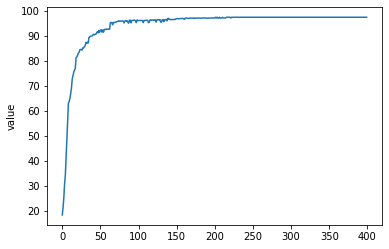

In [64]:
# model_name = ["CNN", "GRU", "LSTM", "LSTM_Atten"]
# filename = "mvd_down_40_sub"
# for name in model_name:
#     for fold_num in range(1):
#         save_name_ce = name + "_Kfold_" + str(fold_num) + "_" + filename + "_bat32"
#         evaluate(save_name_ce)

# batch 32 ce down
# evaluate("CNN_Kfold_0_mvd_down_40_sub_bat32")
# evaluate("GRU_Kfold_0_mvd_down_40_sub_bat32")
# evaluate("LSTM_Kfold_0_mvd_down_40_sub_bat32")
# evaluate("LSTM_Atten_Kfold_0_mvd_down_40_sub_bat32")

# evaluate("CNN_Kfold_0_mvd_down_402_sub_bat32")
# evaluate("GRU_Kfold_0_mvd_down_402_sub_bat32")
# evaluate("LSTM_Kfold_0_mvd_down_402_sub_bat32")
# evaluate("LSTM_Atten_Kfold_0_mvd_down_402_sub_bat32")

#-------------------------------------------------------------
# batch 32 ce all
# evaluate("CNN_Kfold_0_mvd_allkfold_40_sub_bat32")
# evaluate("GRU_Kfold_0_mvd_allkfold_40_sub_bat32")
# evaluate("LSTM_Kfold_1_mvd_allkfold_40_sub_bat32")
# evaluate("LSTM_Atten_Kfold_1_mvd_allkfold_40_sub_bat32")

# evaluate("CNN_Kfold_1_mvd_allkfold_402_sub_bat32")
# evaluate("GRU_Kfold_0_mvd_allkfold_40_sub_bat32")
# evaluate("LSTM_Kfold_0_mvd_allkfold_402_sub_bat32")  # 这个最多326
# evaluate("LSTM_Atten_Kfold_1_mvd_allkfold_402_sub_bat32")

#========================================================================================================
# batch xxx contras2 down (正在FGY1训练，GRU没跑)
# evaluate("Contras2_CNN_Kfold_0_mvd_down_40_sub_bat512_lam0.3_tem0.1")
# evaluate("Contras2_CNN_Kfold_0_mvd_down_40_sub_bat1024_lam0.3_tem0.1")
# evaluate("Contras2_LSTM_Kfold_0_mvd_down_40_sub_bat512_lam0.3_tem0.1")
# evaluate("Contras2_LSTM_Atten_Kfold_0_mvd_down_40_sub_bat256_lam0.3_tem0.1")


# # batch 32 contras down
# evaluate("Contras_CNN_Kfold_0_mvd_down_40_sub_bat32_lam0.3_tem0.1")
# evaluate("Contras_GRU_Kfold_0_mvd_down_40_sub_bat32_lam0.3_tem0.1")
# evaluate("Contras_LSTM_Kfold_0_mvd_down_40_sub_bat32_lam0.3_tem0.1")
# evaluate("Contras_LSTM_Atten_Kfold_0_mvd_down_40_sub_bat32_lam0.3_tem0.1")

# batch 128 contras down(弃没有跑完)
# evaluate("Contras_CNN_Kfold_0_mvd_down_40_sub_bat128_lam0.3_tem0.1")
# evaluate("Contras_GRU_Kfold_0_mvd_down_40_sub_bat128_lam0.3_tem0.1")


# batch 32 contras all 
# evaluate("Contras_CNN_Kfold_0_mvd_allkfold_40_sub_bat32_lam0.3_tem0.1")
# evaluate("Contras_GRU_Kfold_0_mvd_allkfold_40_sub_bat32_lam0.3_tem0.1") 
# evaluate("Contras_LSTM_Kfold_0_mvd_allkfold_40_sub_bat32_lam0.3_tem0.1")
# evaluate("Contras_LSTM_Atten_Kfold_0_mvd_allkfold_40_sub_bat32_lam0.3_tem0.1")


./save/result/LSTM_Kfold_0_mvd_down_402_sub_bat32.result
93.852
91.33300000000001
331
./save/result/Contras_LSTM_Kfold_0_mvd_down_40_sub_bat32_lam0.3_tem0.1.result
95.644
94.45633333333335
355
./save/result/LSTM_Kfold_1_mvd_down_402_sub_bat32.result
95.613
94.23166666666667
314
./save/result/Contras_LSTM_Kfold_1_mvd_down_40_sub_bat32_lam0.3_tem0.1.result
95.363
88.21666666666665
294
./save/result/LSTM_Kfold_2_mvd_down_402_sub_bat32.result
90.001
88.93333333333332
330
./save/result/Contras_LSTM_Kfold_2_mvd_down_40_sub_bat32_lam0.3_tem0.1.result
92.031
90.30466666666666
330
./save/result/LSTM_Kfold_3_mvd_down_402_sub_bat32.result
93.45
93.072
375
./save/result/Contras_LSTM_Kfold_3_mvd_down_40_sub_bat32_lam0.3_tem0.1.result
91.481
87.803
301
./save/result/LSTM_Kfold_4_mvd_down_402_sub_bat32.result
93.743
92.269
341
./save/result/Contras_LSTM_Kfold_4_mvd_down_40_sub_bat32_lam0.3_tem0.1.result
92.317
90.935
386
./save/result/LSTM_Kfold_5_mvd_down_402_sub_bat32.result
93.954
93.6576666666666

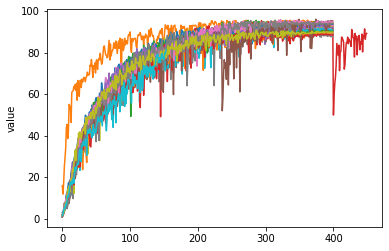

In [131]:
# evalueate
f1_pd_all = pandas.DataFrame()
model_filename = ["CNN", "GRU", "LSTM", "LSTM_Atten"]
model_name = ["CNN", "GRU", "LSTM", "Atten-LSTM"]
model_filename = ["LSTM"]
for i, name in enumerate(model_filename):
    for fold_num in range(10):
        # # filename = "mvd_allkfold_40_sub_bat32"
        # filename = "mvd_allkfold_402_sub_bat32"
        # save_name_ce = name + "_Kfold_" + str(fold_num) + "_" + filename
        # evaluate(save_name_ce)

        # filename = "mvd_down_40_sub_bat32"
        filename = "mvd_down_402_sub_bat32"
        save_name_ce = name + "_Kfold_" + str(fold_num) + "_" + filename
        evaluate(save_name_ce)

        # filename = "mvd_allkfold_40_sub_bat32_lam0.3_tem0.1"
        # save_name_contras = "Contras_" + name + "_Kfold_" + str(fold_num) + "_" + filename
        # evaluate(save_name_contras)

        filename = "mvd_down_40_sub_bat32_lam0.3_tem0.1"
        save_name_contras = "Contras_" + name + "_Kfold_" + str(fold_num) + "_" + filename
        evaluate(save_name_contras)
    print("\n", "="*40,"\n")

/home/passwd123/anaconda3/envs/scan/lib/python3.10/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


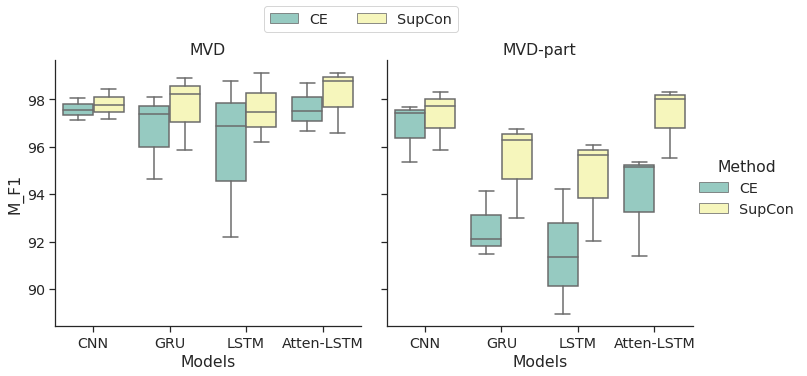

In [93]:
def get_overall_crossdown_performance(f1_pd_all):
    sns.set(context='notebook', palette="Set2",style='ticks')
    p = sns.boxplot(x="Models", y="M_F1",hue="Dataset", data=f1_pd_all[f1_pd_all.Method == "CE"], palette="Set3")
    plt.legend(bbox_to_anchor=(0.5, 1), loc=8, borderaxespad=0.3, ncol=2)
    p.set_ylabel("M_F1")
    p = p.get_figure()
    p.savefig("./save/pic/overall_crossdown-performance.pdf",dpi = 800, facecolor = "w", bbox_inches = 'tight')

def get_overall_performance(f1_pd_all):
    sns.set(context='notebook', palette="Set3",style='ticks', font_scale=1.3)
    p = sns.factorplot(x="Models", y="M_F1", hue="Method", col="Dataset",data=f1_pd_all, kind="box")
    # sns.set_ylabel("M_F1")
    ii = 0
    titles = ["MVD", "MVD-part"]
    for ax, title in zip(p.axes.flat, titles):
        ii+=1
        ax.set_title(title)
        ax.set_ylabel("M_F1")
        if ii == 1: ax.legend(bbox_to_anchor=(1, 1), loc=8, borderaxespad=2, ncol=2)
    p.savefig("./save/pic/overall-performance.pdf",dpi = 800, figsize = (20,6), facecolor = "w", bbox_inches = 'tight')

# overall
f1_pd_all = pandas.DataFrame()
model_filename = ["CNN", "GRU", "LSTM", "LSTM_Atten"]
model_name = ["CNN", "GRU", "LSTM", "Atten-LSTM"]
# model_filename = ["CNN"]
for i, name in enumerate(model_filename):
    for fold_num in range(3):  # 2x 4x 5x
        # filename = "mvd_allkfold_40_sub_bat32"
        filename = "mvd_allkfold_402_sub_bat32"
        save_name_ce = name + "_Kfold_" + str(fold_num) + "_" + filename
        f1_pd_all = get_box_data_overall(save_name_ce, f1_pd_all, 1, "MVD", model_name[i], "CE", fold_num)

        # filename = "mvd_down_40_sub_bat32"
        filename = "mvd_down_402_sub_bat32"
        save_name_ce = name + "_Kfold_" + str(fold_num) + "_" + filename
        f1_pd_all = get_box_data_overall(save_name_ce, f1_pd_all, 1, "MVD-part", model_name[i], "CE", fold_num)

        filename = "mvd_allkfold_40_sub_bat32_lam0.3_tem0.1"
        save_name_contras = "Contras_" + name + "_Kfold_" + str(fold_num) + "_" + filename
        f1_pd_all = get_box_data_overall(save_name_contras, f1_pd_all, 0, "MVD", model_name[i], "SupCon", fold_num)

        filename = "mvd_down_40_sub_bat32_lam0.3_tem0.1"
        save_name_contras = "Contras_" + name + "_Kfold_" + str(fold_num) + "_" + filename
        f1_pd_all = get_box_data_overall(save_name_contras, f1_pd_all, 0, "MVD-part", model_name[i], "SupCon", fold_num)


# p = sns.factorplot(x="Models", y="M_F1", hue="Dataset", col="Method",data=f1_pd_all, kind="box", palette="Set3", height = 5)
# plt.ylim((0, 100))


# get_overall_performance(f1_pd_all)
# f1_pd_all = get_overall_crossdown_performance(f1_pd_all)
# f1_pd_all = get_mean_overall(f1_pd_all)
get_overall_performance(f1_pd_all)
# f1_pd_all
# f1_pd_all.to_excel("./save/excel/overall.xlsx")

           label          f1          num  fold_num
count  39.000000   39.000000    39.000000  39.00000
mean   15.307692   99.182323   297.641026   1.00000
std    12.422717    1.465626   459.242310   0.82717
min     0.000000   92.715232    42.000000   0.00000
25%     3.000000   98.932499    60.000000   0.00000
50%    13.000000   99.803536   146.000000   1.00000
75%    28.000000  100.000000   323.000000   2.00000
max    35.000000  100.000000  1788.000000   2.00000
CE  --  CNN  --  large --------
mean: 99.182
std: 1.466
           label          f1        num  fold_num
count  39.000000   39.000000  39.000000  39.00000
mean   20.153846   98.982411  19.538462   1.00000
std    11.053788    2.330062   7.775962   0.82717
min     4.000000   88.888889   9.000000   0.00000
25%    10.000000   99.122807  14.000000   0.00000
50%    17.000000  100.000000  19.000000   1.00000
75%    30.000000  100.000000  26.500000   2.00000
max    38.000000  100.000000  33.000000   2.00000
CE  --  CNN  --  medium --

/home/passwd123/anaconda3/envs/scan/lib/python3.10/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/passwd123/anaconda3/envs/scan/lib/python3.10/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/passwd123/anaconda3/envs/scan/lib/python3.10/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorp

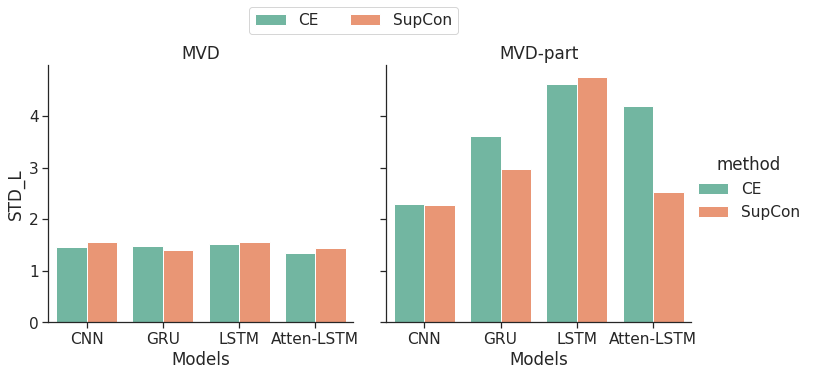

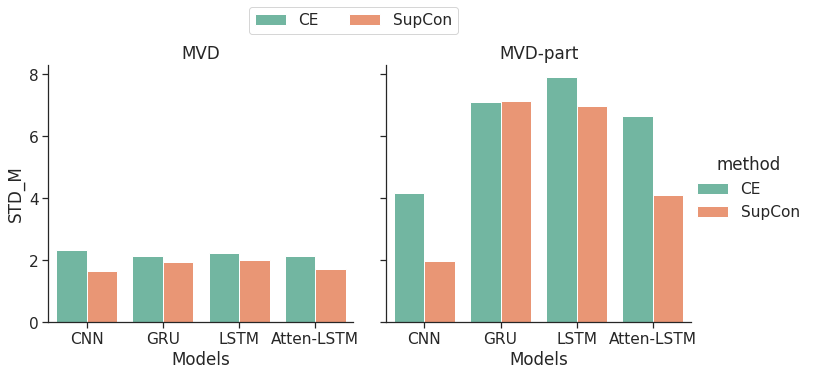

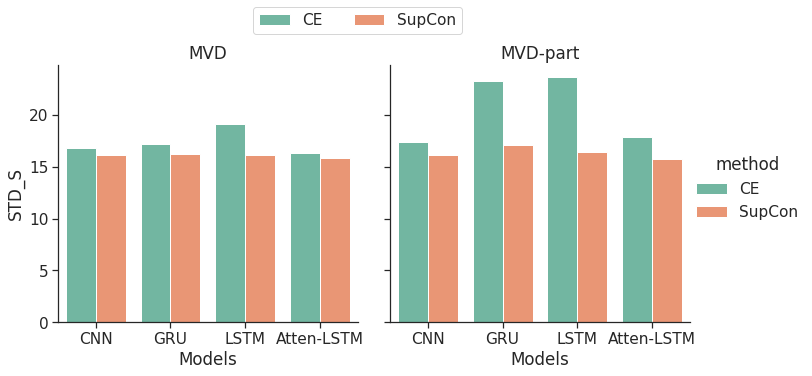

In [7]:
def get_std(f1_pd_all):
    f1_pd_all = get_detail_df(f1_pd_all)
    # 画出比较不同size的mean和std的图
    # for dataset in ["MVD", "MVD-part"]:
    # for size in ["large_mean", "medium_mean", "small_mean", "STD_L", "STD_M", "STD_S"]:
    sns.set(context='notebook', palette="Set3",style='ticks', font_scale=1.4)
    for size in ["STD_L", "STD_M", "STD_S"]:
        pfig = sns.factorplot(x="Models", y=size, hue="method", col="Dataset",data=f1_pd_all, kind="bar", palette="Set2", height = 5,col_wrap = 2)
        # pfig = sns.barplot(x= "Models", y=size,  hue="method",data=f1_pd_all[f1_pd_all.Dataset == dataset], palette="Set3")
        titles = ["MVD", "MVD-part"]
        ii = 0
        for ax, title in zip(pfig.axes.flat, titles):
            ii+=1
            ax.set_title(title)
            # ax.set_ylabel("M_F1")
            if ii == 1: ax.legend(bbox_to_anchor=(1, 1), loc=8, borderaxespad=2, ncol=2)
        pfig.savefig("./save/pic/contras-std/" + size + "_detail.pdf",dpi = 800, facecolor = "w", bbox_inches = 'tight')

def get_four(f1_pd_all):
    f1_pd_all = get_mean_df(f1_pd_all)
    sns.set(context='notebook', palette="Set3",style='ticks', font_scale=1.6)
    # 只用CE，获取整体上四个模型都下滑的图
    p = sns.factorplot(x="size", y="f1", hue="Dataset", col="Models",data=f1_pd_all, kind="box", palette="Set3", height = 5,col_wrap = 2)
    titles = ["CNN", "GRU", "LSTM", "Atten-LSTM"]
    ii = 0
    for ax, title in zip(p.axes.flat, titles):
        ii+=1
        ax.set_title(title)
        ax.set_ylabel("M_F1")
        if ii == 1: ax.legend(bbox_to_anchor=(1, 1), loc=8, borderaxespad=2, ncol=2)
    p.savefig("./save/pic/detail-crossdown-performance.pdf",dpi = 800, facecolor = "w", bbox_inches = 'tight')

def get_eight(f1_pd_all):
    f1_pd_all = get_mean_df(f1_pd_all)
    sns.set(context='notebook', palette="Set3",style='ticks', font_scale=1.8)
    p = sns.factorplot(x="size", y="f1", hue="Method", col="Models", row='Dataset',data=f1_pd_all, kind="box", palette="Set3", height = 5)
    titles = ["MVD | CNN", "MVD | GRU", "MVD | LSTM", "MVD | Atten-LSTM",\
        "MVD-part | CNN", "MVD-part | GRU", "MVD-part | LSTM", "MVD-part | Atten-LSTM"]
    ii = 0
    for ax, title in zip(p.axes.flat, titles):
        ii+=1
        ax.set_title(title)
        ax.set_ylabel("M_F1")
        if ii == 2: ax.legend(bbox_to_anchor=(1, 1), loc=8, borderaxespad=2, ncol=2)
    p.savefig("./save/pic/detail-performance.pdf",dpi = 800, facecolor = "w", bbox_inches = 'tight')
   


# large/medium/small
f1_pd_all = pandas.DataFrame()
model_filename = ["CNN", "GRU", "LSTM", "LSTM_Atten"]
model_name = ["CNN", "GRU", "LSTM", "Atten-LSTM"]
# model_filename = ["CNN", "GRU", "LSTM"]
for i, name in enumerate(model_filename):
    for fold_num in range(3):
        # filename = "mvd_allkfold_40_sub_bat32"
        filename = "mvd_allkfold_402_sub_bat32"
        save_name_ce = name + "_Kfold_" + str(fold_num) + "_" + filename
        f1_pd_all = get_box_data(save_name_ce, f1_pd_all, 1, "MVD", model_name[i], "CE", fold_num)

        

        filename = "mvd_allkfold_40_sub_bat32_lam0.3_tem0.1"
        save_name_contras = "Contras_" + name + "_Kfold_" + str(fold_num) + "_" + filename
        f1_pd_all = get_box_data(save_name_contras, f1_pd_all, 0, "MVD", model_name[i], "SupCon", fold_num)

        
    for fold_num in range(3):  #X345
        # filename = "mvd_down_40_sub_bat32"
        filename = "mvd_down_402_sub_bat32"
        save_name_ce = name + "_Kfold_" + str(fold_num) + "_" + filename
        f1_pd_all = get_box_data(save_name_ce, f1_pd_all, 1, "MVD-part", model_name[i], "CE", fold_num)

        filename = "mvd_down_40_sub_bat32_lam0.3_tem0.1"
        save_name_contras = "Contras_" + name + "_Kfold_" + str(fold_num) + "_" + filename
        f1_pd_all = get_box_data(save_name_contras, f1_pd_all, 0, "MVD-part", model_name[i], "SupCon", fold_num)


pandas.set_option('display.max_rows', 10)
# f1_pd_all
# get_mean_df(f1_pd_all)  
# get_detail_df(f1_pd_all)   # 计算 mean_l/m/s 和 std_l/m/s
# f1_pd_all = get_detail_df(f1_pd_all)
# f1_pd_all = get_mean_df(f1_pd_all)



    

# p = sns.factorplot(x="size", y="f1", hue="Method", col="Models", row='Dataset',data=f1_pd_all, kind="box", palette="Set3", height = 5)
# p.set_titles("11")
# p = sns.factorplot(x="size", y="f1", hue="Method", col="Dataset", row='Models',data=f1_pd_all, kind="box", palette="Set3", height = 4)
# plt.ylim((0.4, 1))
# 
# f1_pd_all.to_excel("./save/excel/detail.xlsx")
# f1_pd_all

get_std(f1_pd_all)
# get_four(f1_pd_all)
# get_eight(f1_pd_all)



In [188]:
for model_name in ["CNN", "GRU", "LSTM", "Atten-LSTM"][0:1]:
    p = sns.boxplot(x="size", y="f1",hue="Dataset", data=f1_pd_all[f1_pd_all.Models== model_name], palette="Set3")
    p.set_ylabel("M_F1 Scores")
    p.set_xlabel("Vulnerability Type Scales")
    p.set_title(model_name + " Performance")

    p.set_title("M_F1 on MVD-part")
    p.set_xticks([])

    fig = p.get_figure()
    fig.savefig("./save/pic/" + model_name + "-ce-performance.png",dpi = 400, facecolor = "w")
    fig.clear()
fig.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
# 分析大中小数据集
model_filename = ["CNN", "GRU", "LSTM", "LSTM_Atten"]
model_name = ["CNN", "GRU", "LSTM", "Atten-LSTM"]

for i, name in enumerate(model_filename):
    for size in ["large", "medium", "small"][2:3]:
        print(name, " -- " , size, "--------")
        f1_pd_tem = f1_pd_all[f1_pd_all["Models"] == model_name[i]]
        f1_pd_tem = f1_pd_tem[f1_pd_tem["size"] == size]
        f1_pd_tem = f1_pd_tem[f1_pd_tem["Dataset"] == "MVD-part"]
        f1_pd_tem = f1_pd_tem[f1_pd_tem["Method"] == "CE"]
        # print(f1_pd_tem.describe())
        print("mean:", f1_pd_tem.describe()["f1"]["mean"])
        print("std:", f1_pd_tem.describe()["f1"]["std"])
        print()
    
    for size in ["large", "medium", "small"][2:3]:
        print(name, " -- " , size, "--------")
        f1_pd_tem = f1_pd_all[f1_pd_all["Models"] == model_name[i]]
        f1_pd_tem = f1_pd_tem[f1_pd_tem["size"] == size]
        f1_pd_tem = f1_pd_tem[f1_pd_tem["Dataset"] == "MVD-part"]
        f1_pd_tem = f1_pd_tem[f1_pd_tem["Method"] == "SupCon"]
        # print(f1_pd_tem.describe())
        print("mean:", f1_pd_tem.describe()["f1"]["mean"])
        print("std:", f1_pd_tem.describe()["f1"]["std"])
        print()

In [92]:
# Counter([2,2,3,1,1,1])
li = [2,2,3,3,2,21,55,32,2,321,1,1,1]
resul = 0
max_num = sorted(dict(Counter(li)).items(), key=lambda x: x[1], reverse=True)[0][0]
for index, i in enumerate(li):
    if i == max_num: resul = index
li[resul]

2